## confounder analysis
achen@2021-5-22

In [1]:
import pandas as pd
import os
import glob
from Bio import Seq
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import re
from scipy.stats import wilcoxon,mannwhitneyu
import numpy as np

In [2]:
cf = pd.read_csv('/data1/chenyaowen/workspace/metaSNP_finalversion/msystem_revision/confounders.csv')

In [34]:
cf['type'] = cf['Sample ID'].str[0]
cf = cf.rename({' Gender ':'Gender','BMI (kg/m2)':'BMI'},axis=1)
cf['Sex'] = [1 if x == 'female' else 0 for x in cf['Gender']]
cf

,Stage,Sample ID,Country,Gender,Age,BMI,type,Sex
0,discovery,HD-1,China,female,40,20.03,H,1
1,discovery,HD-2,China,female,46,20.83,H,1
2,discovery,HD-3,China,male,45,19.58,H,0
3,discovery,HD-4,China,male,38,20.05,H,0
4,discovery,HD-5,China,female,43,22.38,H,1
...,...,...,...,...,...,...,...,...
232,validation,LV-21,China,female,49,22.89,L,1
233,validation,LV-22,China,female,52,22.48,L,1
234,validation,LV-23,China,male,48,22.84,L,0
235,validation,LV-24,China,male,60,19.57,L,0


In [173]:
cf['type'] = cf['type'] + 'C'

### age vs group

Text(0, 0.5, 'Age')

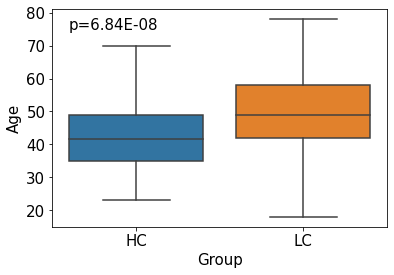

In [176]:
sns.boxplot(data=cf,x='type',y='Age')
a = cf[cf['type']=='HC']['Age']
b = cf[cf['type']=='LC']['Age']
s,p = mannwhitneyu(a,b)
plt.text(-0.4,75,"p=" +'%.2E'%p,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Group',fontsize=15)
plt.ylabel('Age',fontsize=15)


In [36]:
cf.groupby(['type','Sex']).size()

type  Sex
H     0      72
      1      42
L     0      84
      1      39
dtype: int64

In [37]:
import scipy.stats as stats
oddsratio, pvalue = stats.fisher_exact([[72, 42], [84, 39]])
oddsratio,pvalue

(0.7959183673469388, 0.4146444096036285)

Text(0, 0.5, 'BMI')

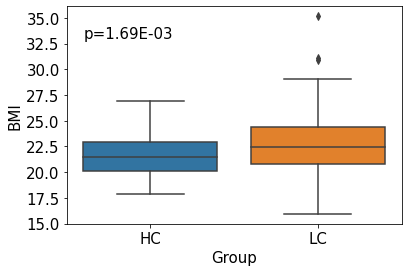

In [179]:
sns.boxplot(data=cf,x='type',y='BMI')
#sns.swarmplot(data=cf,x='type',y='BMI',color='0.25')
a = cf[cf['type']=='HC']['BMI']
b = cf[cf['type']=='LC']['BMI']
s,p = mannwhitneyu(a,b)
plt.text(-0.4,33,"p="+"%.2E"%p,fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Group',fontsize=15)
plt.ylabel('BMI',fontsize=15)


In [41]:
import dask.dataframe as dd
from dask import delayed
def read_and_label_csv(filename):
    df_csv = pd.read_csv(filename,dtype={'best_mean_nm':str})
    df_csv['filename'] = os.path.basename(filename).replace('.csv','').replace('stat.','')
    return df_csv
fnames = glob.glob(f'../predict_cov//stats/*.csv')
dfs = [delayed(read_and_label_csv)(fname) for fname in fnames]
df = dd.from_delayed(dfs)
df = df.compute()
df['genome'] = df.src.apply(lambda d: '_'.join(d.split('-')[2].split('_')[:2]))
df['type'] = df['filename'].str[0]

In [44]:
meta = pd.read_csv('../data/smp.count.txt',sep='\t')
meta['smp'] = meta['smp'].str.replace('_1P','')
smp2count = dict(meta.set_index('smp')['count'])
df['relative abundance'] = df['best'] / df.filename.map(smp2count)
df['consist_best'] = df['consist']/df['best']

In [ ]:
arrs = []
smps = []
genomes = df.genome.unique()
for smp in df.filename.unique():
    print(smp)
    smps.append(smp)
    arr = []
    for genome in genomes:
        tmpdf1 = df[df.filename==smp]
        tmpdf2 = tmpdf1[tmpdf1.src.str.contains(genome)]
        if len(tmpdf2)==0:
            arr.append(0)
        else:
            arr.append(tmpdf2.reset_index(drop=True).loc[0]['sum-cov'])
    arrs.append(arr)

In [46]:
covdf = pd.DataFrame(arrs)
covdf['smp'] = smps
covdf = covdf.set_index('smp')
covdf.columns = genomes

In [47]:
covdf

,GCA_008680095.1,GCA_003467805.1,GCA_003433995.1,GCA_003465525.1,GCA_003434165.1,GCA_003434175.1,GCA_002549775.1,GCA_014868765.1,GCA_014868685.1,GCA_014868665.1,...,GCA_003287415.1,GCA_001916555.1,GCA_003287495.1,GCA_008662345.1,GCA_008671525.1,GCA_014868805.1,GCA_008671395.1,GCA_004558805.1,GCA_002313795.1,GCA_002404655.1
smp,,,,,,,,,,,,,,,,,,,,,
HD-29,78.469928,76.745342,75.962481,71.278983,70.515794,70.037490,69.930791,69.896505,69.250906,69.208592,...,13.329493,12.114434,11.669058,10.688069,9.042606,8.806362,8.797670,8.289839,2.433992,2.370495
HD-31,8.631881,9.355666,60.467169,10.072738,9.581158,9.094087,8.188115,5.718205,3.925290,4.092637,...,5.995114,6.260338,5.256707,3.637226,3.655062,3.581938,3.509575,2.679339,1.241528,1.272857
LD-16,70.845927,71.341397,69.303663,66.759925,12.210629,11.298069,9.070163,68.084384,66.811633,36.850115,...,9.833885,10.740035,9.852393,6.293017,6.268623,6.350056,6.128528,5.943564,2.697614,2.743728
LD-22,71.522453,72.214861,72.455938,68.282985,55.031893,55.372606,15.385806,64.447655,63.480243,74.032021,...,57.121298,13.534923,56.413303,12.386063,9.277600,8.864128,9.274759,7.744180,1.812946,1.868019
LD-26,38.288644,39.890678,78.773503,39.948780,12.882935,12.119137,8.767015,51.169889,44.291441,12.990206,...,33.941306,12.061465,32.878863,7.341682,5.114154,5.283542,4.961404,2.945773,2.103740,2.110593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LD-87,6.030779,6.403121,55.254600,6.710625,7.226637,5.963715,2.409398,3.327410,2.568015,1.947990,...,4.368293,3.008961,3.902463,1.735382,1.709808,1.862926,1.641834,0.819424,0.541435,0.514287
LD-9,6.553754,7.796260,46.099455,7.729597,7.219051,6.565894,4.320911,3.109369,1.760543,1.722821,...,5.444829,6.472478,4.659084,2.648178,2.613832,3.478424,2.554204,1.275031,1.444231,1.389947
LD-95,70.189892,70.005716,81.827248,67.449710,52.834860,54.879029,10.782227,55.591967,54.496512,27.552396,...,11.743829,14.037066,10.356280,8.664392,6.286209,6.348257,6.306493,4.371304,2.537398,2.694286


In [48]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import KFold


In [115]:
def train(subX,y):
    x_train, x_test, y_train, y_test = train_test_split(subX,y,train_size=0.9)
    kf = KFold(n_splits=5,shuffle=True,random_state=110002)
    res = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    i = 0
    plt.figure(figsize=(8,6))
    fig, ax = plt.subplots(figsize=(8,6))
    
    for train, test in kf.split(subX):
        i += 1
        clf = svm.SVC(kernel='rbf',probability=True,C=1,gamma='scale')
        clf.fit(subX[train], y[train])
        y_pred= clf.predict(subX[test])
        pred = clf.predict_proba(subX[train])[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y[train], pred, pos_label=1)
        pred_test = clf.predict_proba(subX[test])[:,1]
        fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y[test], pred_test, pos_label=1)
        res.append([accuracy_score(y[test], y_pred),metrics.auc(fpr, tpr),metrics.auc(fpr_test, tpr_test)])
        
        viz = plot_roc_curve(clf, subX[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')
    
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()
    return mean_auc
    
    

In [191]:
from sklearn.ensemble import RandomForestClassifier

def train_rf(subX,y):
    RSEED = 0
    x_train, x_test, y_train, y_test = train_test_split(subX,y,train_size=0.9)
    kf = KFold(n_splits=5,shuffle=True,random_state=110002)
    res = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    i = 0
    plt.figure(figsize=(8,6))
    fig, ax = plt.subplots(figsize=(8,6))
    
    for train, test in kf.split(subX):
        i += 1
        
        param_grid = {
            'n_estimators': np.linspace(10, 200).astype(int),
            'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
            'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
            'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
            'min_samples_split': [2, 5, 10],
            'bootstrap': [True, False]
        }
        
        # Estimator for use in random search
        estimator = RandomForestClassifier(random_state = RSEED)
        
        # Create the random search model
        rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                                #scoring = 'roc_auc', cv = 3, 
                                #n_iter = 10, verbose = 1, random_state=RSEED)
                                scoring = 'roc_auc', cv = 3, 
                                n_iter = 100, verbose = 1, random_state=RSEED)
        
        rs.fit(subX[train], y[train])
        
        clf = rs.best_estimator_

        
        y_pred= clf.predict(subX[test])
        pred = clf.predict_proba(subX[train])[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y[train], pred, pos_label=1)
        pred_test = clf.predict_proba(subX[test])[:,1]
        fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y[test], pred_test, pos_label=1)
        res.append([accuracy_score(y[test], y_pred),metrics.auc(fpr, tpr),metrics.auc(fpr_test, tpr_test)])
        
        viz = plot_roc_curve(clf, subX[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')
    
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()
    return mean_auc

<Figure size 576x432 with 0 Axes>

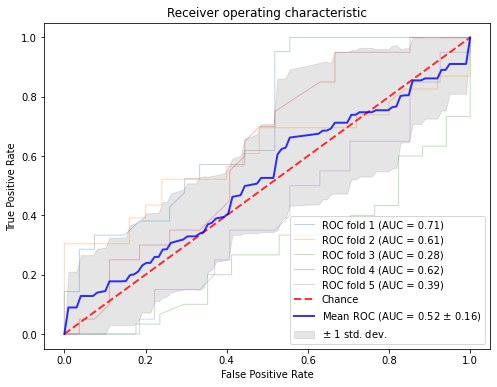

In [52]:
subX = cf.set_index('Sample ID')[['BMI']].to_numpy()
y = np.array(cf['Sample ID'].str[0].map({'H':1,'L':0}))
train(subX,y)

<Figure size 576x432 with 0 Axes>

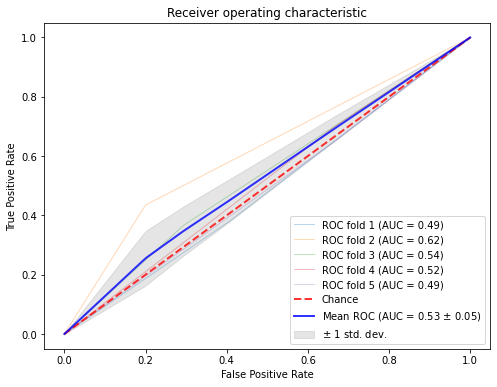

In [54]:
subX = cf.set_index('Sample ID')[['Sex']].to_numpy()
y = np.array(cf['Sample ID'].str[0].map({'H':1,'L':0}))
train(subX,y)

<Figure size 576x432 with 0 Axes>

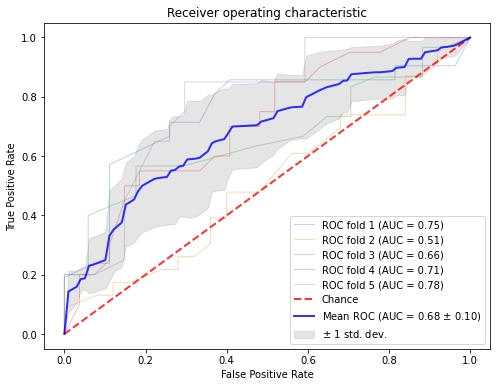

In [55]:
subX = cf.set_index('Sample ID')[['Age']].to_numpy()
y = np.array(cf['Sample ID'].str[0].map({'H':1,'L':0}))
train(subX,y)


/home/achen/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Text(27.125, 0.5, 'Coverage')

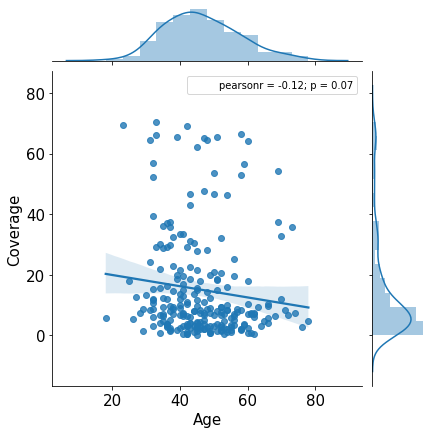

In [182]:
smps = list(cf['Sample ID'])
a = covdf['GCA_001406615.2'][smps]
b = cf.set_index('Sample ID')['Age'][smps]
sns.jointplot(data=pd.DataFrame({'cov':a,'age':b}),x='age',y='cov',kind='reg',stat_func=pearsonr)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Age',fontsize=15)
plt.ylabel('Coverage',fontsize=15)

In [59]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [69]:
X_df = pd.DataFrame({'cov':covdf['GCA_001406615.2'][smps],'age':cf.set_index('Sample ID')['Age'][smps],'BMI':cf.set_index('Sample ID')['BMI'][smps]})
y = np.array(pd.Series(smps).str[0].map({'H':1,'L':0}))

In [70]:
X_df['type'] = [0 if x == 'H' else 1 for x in X_df.index.str[0]]
X_df['sex'] = [0 if x == 'female' else 1 for x in cf.set_index('Sample ID')['Gender'][list(X_df.index)]]
X_df

,cov,age,BMI,type,sex
HD-1,33.554705,40,20.03,0,0
HD-2,7.533735,46,20.83,0,0
HD-3,2.942748,45,19.58,0,1
HD-4,14.816975,38,20.05,0,1
HD-5,46.710369,43,22.38,0,0
...,...,...,...,...,...
LV-21,7.467204,49,22.89,1,0
LV-22,1.497105,52,22.48,1,0
LV-23,14.257232,48,22.84,1,1
LV-24,10.526160,60,19.57,1,1


In [71]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Load data
dat = X_df
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('type ~ cov + age + sex + BMI', data=dat).fit()
# Inspect the results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                   type   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     18.91
Date:                Sat, 22 May 2021   Prob (F-statistic):           1.79e-13
Time:                        23:26:25   Log-Likelihood:                -138.40
No. Observations:                 237   AIC:                             286.8
Df Residuals:                     232   BIC:                             304.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4241      0.274     -1.547      0.1

In [73]:
dat = X_df
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('type ~ cov + age + cov*age', data=dat).fit()
# Inspect the results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                   type   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     23.69
Date:                Sat, 22 May 2021   Prob (F-statistic):           2.03e-13
Time:                        23:27:03   Log-Likelihood:                -140.29
No. Observations:                 237   AIC:                             288.6
Df Residuals:                     233   BIC:                             302.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0430      0.171      0.252      0.8

<Figure size 576x432 with 0 Axes>

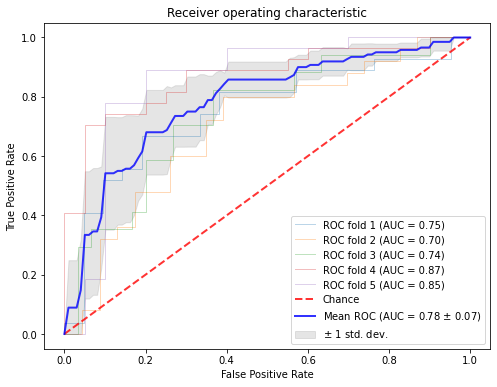

In [88]:
subX = pd.DataFrame({'cov':covdf['GCA_001406615.2'][smps],'age':cf.set_index('Sample ID')['Age'][smps]}).to_numpy()
y = np.array([0 if x[0]=='H' else 1 for x in smps])
train(subX,y)

<Figure size 576x432 with 0 Axes>

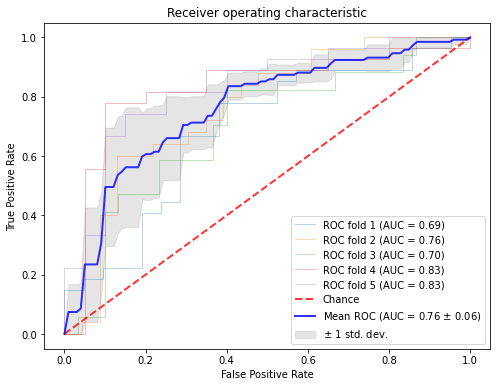

In [89]:
subX = pd.DataFrame({'cov':covdf['GCA_001406615.2'][smps]}).to_numpy()
y = np.array([0 if x[0]=='H' else 1 for x in smps])
train(subX,y)

<Figure size 576x432 with 0 Axes>

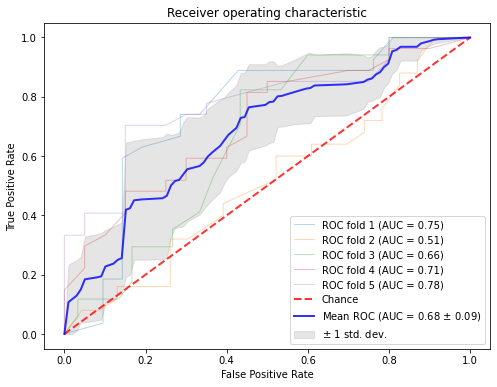

In [90]:
subX = pd.DataFrame({'age':cf.set_index('Sample ID')['Age'][smps]}).to_numpy()
y = np.array([0 if x[0]=='H' else 1 for x in smps])
train(subX,y)

In [91]:
p = 0
while p < 0.1:
    hcf = cf[cf['type']=='H'].sample(frac=0.5)
    lcf = cf[cf['type']=='L'].sample(frac=0.5)
    s,p = mannwhitneyu(hcf['Age'],lcf['Age'])
print(p)


0.12732803078869265


In [92]:
newcf = cf.loc[list(hcf.index) + list(lcf.index)]

Text(-0.4, 75, 'p=0.12732803078869265')

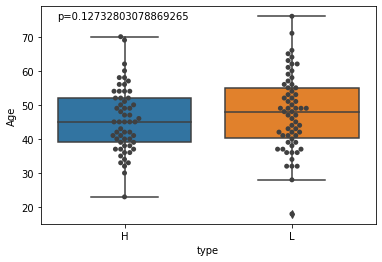

In [94]:
sns.boxplot(data=newcf,x='type',y='Age')
sns.swarmplot(data=newcf,x='type',y='Age',color='0.25')
a = newcf[newcf['type']=='H']['Age']
b = newcf[newcf['type']=='L']['Age']
s,p = mannwhitneyu(a,b)
plt.text(-0.4,75,f"p={p}")

<Figure size 576x432 with 0 Axes>

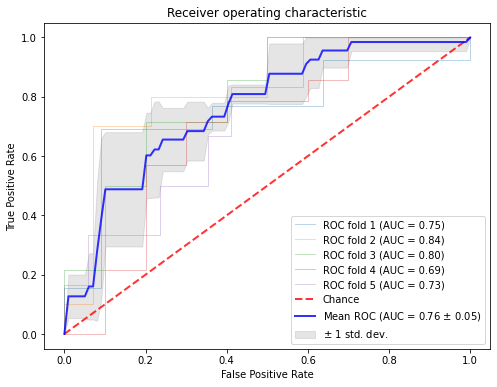

In [95]:
subX = covdf.loc[list(newcf['Sample ID'])].to_numpy()
y = np.array(newcf['Sample ID'].str[0].map({'H':1,'L':0}))
train(subX,y)

In [96]:
abun_dict = {}
for f in glob.glob('../metaphlan2/res/*.result.txt'):
    name = os.path.basename(f).replace('.result.txt','')
    c = 0
    with open(f,'r') as inpf:
        for line in inpf:
            line = line.strip()
            if line[0] == '#':
                continue
            tail = line.split('\t')[0].split('|')[-1]
            num = float(line.split('\t')[1])
            if not tail.startswith('s__'):
                continue
            species = tail.replace('s__','')
            if species not in abun_dict:
                abun_dict[species] = {}
            abun_dict[species][name] = num

In [97]:
mp_fp = pd.DataFrame(abun_dict['Faecalibacterium_prausnitzii'].items(),columns=['smp','abun'])
mp_fp['type']= mp_fp['smp'].str[0]

In [159]:
mp_fp['type'] += 'C'
mp_fp

,smp,abun,type,age,group
0,HD-1,0.02130,HC,40,0
1,HD-10,3.63347,HC,40,0
2,HD-11,14.91863,HC,38,0
3,HD-12,9.83833,HC,40,0
4,HD-13,11.60992,HC,56,0
...,...,...,...,...,...
232,LV-5,2.50567,LC,40,1
233,LV-6,0.01562,LC,42,1
234,LV-7,3.93690,LC,42,1
235,LV-8,3.25675,LC,65,1


Text(0, 0.5, 'Relative Abundance')

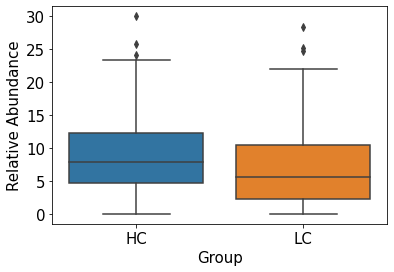

In [161]:
sns.boxplot(data=mp_fp,x='type',y='abun')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Group',fontsize=15)
plt.ylabel('Relative Abundance',fontsize=15)


<Figure size 576x432 with 0 Axes>

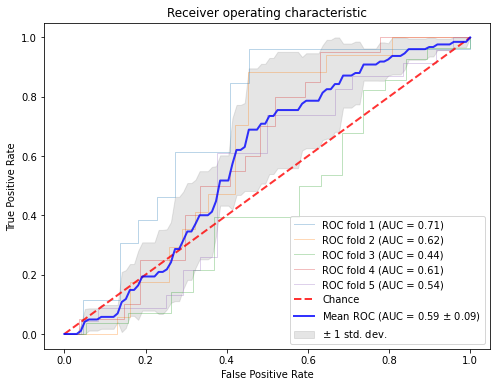

In [98]:
subX = mp_fp[['abun']].to_numpy()
y = np.array(mp_fp['type'].str[0].map({'H':1,'L':0}))
train(subX,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.0s finished


<Figure size 576x432 with 0 Axes>

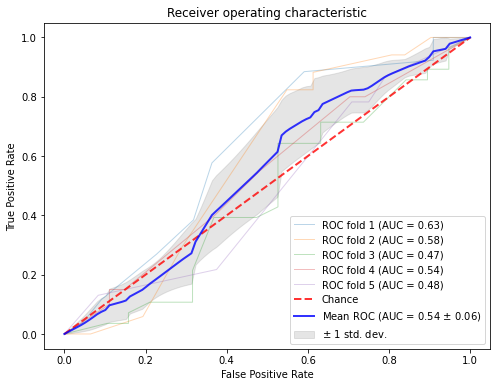

0.5403475267115506

In [192]:
subX = mp_fp[['abun']].to_numpy()
y = np.array(mp_fp['type'].str[0].map({'H':1,'L':0}))
train_rf(subX,y)

In [101]:
mp_fp

,smp,abun,type
0,HD-1,0.02130,H
1,HD-10,3.63347,H
2,HD-11,14.91863,H
3,HD-12,9.83833,H
4,HD-13,11.60992,H
...,...,...,...
232,LV-5,2.50567,L
233,LV-6,0.01562,L
234,LV-7,3.93690,L
235,LV-8,3.25675,L


<Figure size 576x432 with 0 Axes>

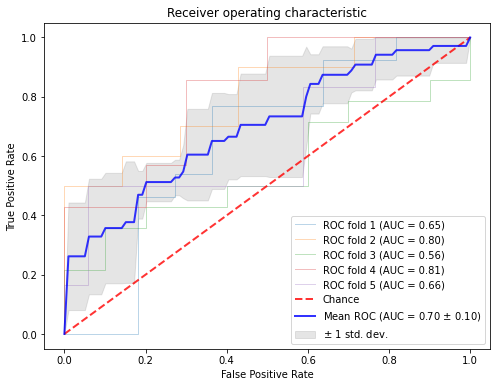

In [114]:
new_mp_fp = mp_fp.set_index('smp').loc[newcf['Sample ID']].reset_index()
subX = new_mp_fp[['abun']].to_numpy()
y = np.array(new_mp_fp['type'].str[0].map({'H':1,'L':0}))
train(subX,y)

In [132]:
dict(X_df['age'])

{'HD-1': 40,
 'HD-2': 46,
 'HD-3': 45,
 'HD-4': 38,
 'HD-5': 43,
 'HD-6': 38,
 'HD-7': 37,
 'HD-8': 60,
 'HD-9': 39,
 'HD-10': 40,
 'HD-11': 38,
 'HD-12': 40,
 'HD-13': 56,
 'HD-14': 51,
 'HD-15': 56,
 'HD-16': 41,
 'HD-17': 46,
 'HD-18': 43,
 'HD-19': 57,
 'HD-20': 45,
 'HD-21': 37,
 'HD-22': 41,
 'HD-23': 35,
 'HD-24': 36,
 'HD-25': 49,
 'HD-26': 40,
 'HD-27': 45,
 'HD-28': 33,
 'HD-29': 33,
 'HD-30': 54,
 'HD-31': 43,
 'HD-32': 54,
 'HD-33': 34,
 'HD-34': 40,
 'HD-35': 48,
 'HD-36': 32,
 'HD-37': 45,
 'HD-38': 40,
 'HD-39': 51,
 'HD-40': 41,
 'HD-41': 52,
 'HD-42': 50,
 'HD-43': 36,
 'HD-44': 41,
 'HD-45': 37,
 'HD-46': 35,
 'HD-47': 58,
 'HD-48': 31,
 'HD-49': 41,
 'HD-50': 50,
 'HD-51': 37,
 'HD-52': 50,
 'HD-53': 50,
 'HD-54': 47,
 'HD-55': 37,
 'HD-56': 31,
 'HD-57': 32,
 'HD-58': 52,
 'HD-59': 23,
 'HD-60': 34,
 'HD-61': 31,
 'HD-62': 62,
 'HD-63': 42,
 'HD-64': 29,
 'HD-65': 43,
 'HD-66': 42,
 'HD-67': 32,
 'HD-68': 33,
 'HD-69': 26,
 'HD-70': 52,
 'HD-71': 36,
 'HD-72': 47,
 

In [136]:
mp_fp['age']=mp_fp['smp'].map(dict(X_df['age']))
mp_fp['group'] = [0 if x == 'H' else 1 for x in mp_fp['type']]

In [137]:
mp_fp

,smp,abun,type,age,group
0,HD-1,0.02130,H,40,0
1,HD-10,3.63347,H,40,0
2,HD-11,14.91863,H,38,0
3,HD-12,9.83833,H,40,0
4,HD-13,11.60992,H,56,0
...,...,...,...,...,...
232,LV-5,2.50567,L,40,1
233,LV-6,0.01562,L,42,1
234,LV-7,3.93690,L,42,1
235,LV-8,3.25675,L,65,1


In [143]:
dat = mp_fp
results = smf.ols('group ~ abun + age + abun*age', data=dat).fit()
# Inspect the results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  group   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     12.37
Date:                Sun, 23 May 2021   Prob (F-statistic):           1.54e-07
Time:                        14:19:25   Log-Likelihood:                -154.32
No. Observations:                 237   AIC:                             316.6
Df Residuals:                     233   BIC:                             330.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0755      0.220     -0.344      0.7

In [ ]:
res = []
while(len(res) < 200):
    print(f'len of res: {len(res)}')
    p = 0
    while p < 0.1:
        hcf = cf[cf['type']=='H'].sample(frac=0.5)
        lcf = cf[cf['type']=='L'].sample(frac=0.5)
        s,p = mannwhitneyu(hcf['Age'],lcf['Age'])
    print(p)
    newcf = cf.loc[list(hcf.index) + list(lcf.index)]
    
    #our tool
    subX = covdf.loc[list(newcf['Sample ID'])].to_numpy()
    y = np.array(newcf['Sample ID'].str[0].map({'H':1,'L':0}))
    auc_our = train(subX,y)
    
    #metaphlan2
    new_mp_fp = mp_fp.set_index('smp').loc[newcf['Sample ID']].reset_index()
    subX = new_mp_fp[['abun']].to_numpy()
    y = np.array(new_mp_fp['type'].str[0].map({'H':1,'L':0}))
    auc_mta = train(subX,y)
    
    res.append([auc_our,'strain'])
    res.append([auc_mta,'metaphlan'])


In [124]:
len(res)

200

In [183]:
res

[[0.7441336441336441, 'strain'],
 [0.6280726680726681, 'metaphlan'],
 [0.761062641062641, 'strain'],
 [0.6388152588152589, 'metaphlan'],
 [0.7057083657083657, 'strain'],
 [0.5237510637510638, 'metaphlan'],
 [0.7644067044067044, 'strain'],
 [0.7050357050357051, 'metaphlan'],
 [0.6426810226810227, 'strain'],
 [0.5036729600365963, 'metaphlan'],
 [0.7395419395419396, 'strain'],
 [0.7000310800310802, 'metaphlan'],
 [0.6115824915824916, 'strain'],
 [0.379576203818628, 'metaphlan'],
 [0.728561890784113, 'strain'],
 [0.532730030911849, 'metaphlan'],
 [0.7371872571872573, 'strain'],
 [0.5149573434421919, 'metaphlan'],
 [0.6692403892403893, 'strain'],
 [0.3866200466200466, 'metaphlan'],
 [0.7421304621304622, 'strain'],
 [0.4174003774003774, 'metaphlan'],
 [0.7396714396714397, 'strain'],
 [0.4954475154475154, 'metaphlan'],
 [0.6844807044807044, 'strain'],
 [0.5085912740458194, 'metaphlan'],
 [0.6971251643978917, 'strain'],
 [0.5151981351981353, 'metaphlan'],
 [0.7193835793835793, 'strain'],
 [0.4

Text(0, 0.5, 'Density')

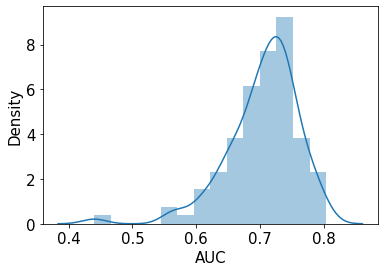

In [186]:
pltdf=  pd.DataFrame(res,columns=['AUC','type'])
pltdf = pltdf[pltdf['type']=='strain']
#sns.boxplot(data=pltdf,x='type',y='AUC')
#sns.swarmplot(data=pltdf,x='type',y='AUC',color='0.3')
sns.distplot(pltdf['AUC'])

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('AUC',fontsize=15)
plt.ylabel('Density',fontsize=15)


<AxesSubplot:xlabel='type', ylabel='AUC'>

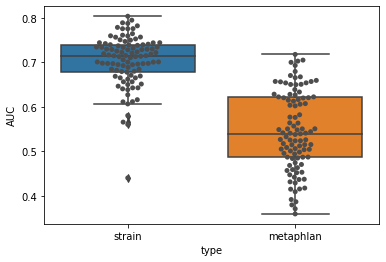

In [128]:
pltdf=  pd.DataFrame(res,columns=['AUC','type'])
sns.boxplot(data=pltdf,x='type',y='AUC')
sns.swarmplot(data=pltdf,x='type',y='AUC',color='0.3')

In [149]:
pltdf[pltdf['type']=='strain']['AUC'].median(),pltdf[pltdf['type']=='metaphlan']['AUC'].median()

(0.7148869648869649, 0.5400014015165531)

In [148]:
pltdt

,AUC,type
0,0.744134,strain
1,0.628073,metaphlan
2,0.761063,strain
3,0.638815,metaphlan
4,0.705708,strain
...,...,...
195,0.437260,metaphlan
196,0.611156,strain
197,0.463242,metaphlan
198,0.640435,strain
